In [52]:

from __future__ import print_function
import os
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision import transforms

import tensorflow
from keras.optimizers import SGD
from keras import regularizers


import matplotlib.pyplot as plt
from PIL import Image

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from PIL import Image
import cv2


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# AlexNet on MNIST

In [11]:
# Following the overal AlexNet architecture
# it has 5 convolutional layers (convolutional, pooling and relu)
# and three fully connected layer

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()

        # MNIST is 28x28, while the initial input size of AlexNet is 227x227. 
        # Hence, the network parameters need to be adjusted
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu2 = nn.ReLU()


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu3 = nn.ReLU()

        self.fc6 = nn.Linear(256*3*3, 1024)  
        self.fc7 = nn.Linear(1024, 512)
        self.fc8 = nn.Linear(512, 10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool3(x)
        x = self.relu3(x)
        x = x.view(-1, 256 * 3 * 3)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.fc7(x)
        x = F.relu(x)
        x = self.fc8(x)
        return x
    
    
#transform
transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomGrayscale(),
                    transforms.ToTensor(),


])

transform1 = transforms.Compose([
                    transforms.ToTensor()
])

# load the data with torch
trainset = torchvision.datasets.MNIST(root='.',train=True,download=False,transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,shuffle=True,num_workers=0)

testset = torchvision.datasets.MNIST(root='.',train=False,download=True,transform=transform1)
testloader = torch.utils.data.DataLoader(testset,batch_size=100,shuffle=False,num_workers=0)

start_ts = time.time()
# call the AlexNet function implemented earlier on
alexnet = AlexNet()

#uses cross entropy loss 
criterion = nn.CrossEntropyLoss()

# use Stochastic gradient descent (SGD) as an optimizer
optimizer = optim.SGD(alexnet.parameters(),lr=1e-3, momentum=0.9)

#device : GPU or CPU
#in my case I use a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

alexnet.to(device)

print("Start Training!")

#same as for ResNet we use 100 epochs for better somparison
num_epochs = 50 

for epoch in range(num_epochs):
    running_loss = 0
    batch_size = 100

    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('[%d, %5d] loss:%.4f'%(epoch+1, (i+1)*100, loss.item()))

print("Finished Traning")


# Save the trained model 
torch.save(alexnet, 'MNIST.pkl')
alexnet = torch.load('MNIST.pkl')

# Classification
with torch.no_grad():
    correct = 0
    total = 0

    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        out = alexnet(images)
        _, predicted = torch.max(out.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('AlexNet accuracy on the 10000 test images:{}%'.format(100 * correct / total)) 
print(f"Training time: {time.time()-start_ts}s") 

Start Training!
[1, 60000] loss:2.2961
[2, 60000] loss:2.2989
[3, 60000] loss:2.2871
[4, 60000] loss:2.2249
[5, 60000] loss:0.8960
[6, 60000] loss:0.3668
[7, 60000] loss:0.3295
[8, 60000] loss:0.2702
[9, 60000] loss:0.2556
[10, 60000] loss:0.1289
[11, 60000] loss:0.2772
[12, 60000] loss:0.1409
[13, 60000] loss:0.0986
[14, 60000] loss:0.0389
[15, 60000] loss:0.0997
[16, 60000] loss:0.0680
[17, 60000] loss:0.0403
[18, 60000] loss:0.0427
[19, 60000] loss:0.0785
[20, 60000] loss:0.0425
[21, 60000] loss:0.0529
[22, 60000] loss:0.0527
[23, 60000] loss:0.0436
[24, 60000] loss:0.0312
[25, 60000] loss:0.0394
[26, 60000] loss:0.0103
[27, 60000] loss:0.0613
[28, 60000] loss:0.2423
[29, 60000] loss:0.0840
[30, 60000] loss:0.0643
[31, 60000] loss:0.0634
[32, 60000] loss:0.0486
[33, 60000] loss:0.0120
[34, 60000] loss:0.0308
[35, 60000] loss:0.0537
[36, 60000] loss:0.0109
[37, 60000] loss:0.0202
[38, 60000] loss:0.0425
[39, 60000] loss:0.0054
[40, 60000] loss:0.0394
[41, 60000] loss:0.0076
[42, 6000

/homes/es314/miniconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


AlexNet accuracy on the 10000 test images:98.25%
Training time: 324.33031010627747s


# RESNET

In [32]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
GRAYSCALE = True

In [33]:
# Checking the dataset
for images, labels in trainloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


In [42]:
start_ts = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(trainloader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 100
Epoch: 2 | Batch index: 0 | Batch size: 100


In [43]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [44]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [45]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(trainloader):
        
        features = features.to(device)
        targets = targets.to(device)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(trainloader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, trainloader, device=device)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 0000/0600 | Cost: 2.6274
Epoch: 001/050 | Batch 0050/0600 | Cost: 0.3138
Epoch: 001/050 | Batch 0100/0600 | Cost: 0.3192
Epoch: 001/050 | Batch 0150/0600 | Cost: 0.1480
Epoch: 001/050 | Batch 0200/0600 | Cost: 0.1291
Epoch: 001/050 | Batch 0250/0600 | Cost: 0.0456
Epoch: 001/050 | Batch 0300/0600 | Cost: 0.1137
Epoch: 001/050 | Batch 0350/0600 | Cost: 0.1247
Epoch: 001/050 | Batch 0400/0600 | Cost: 0.0374
Epoch: 001/050 | Batch 0450/0600 | Cost: 0.0919
Epoch: 001/050 | Batch 0500/0600 | Cost: 0.1090
Epoch: 001/050 | Batch 0550/0600 | Cost: 0.0966
Epoch: 001/050 | Train: 97.133%
Time elapsed: 0.34 min
Epoch: 002/050 | Batch 0000/0600 | Cost: 0.1320
Epoch: 002/050 | Batch 0050/0600 | Cost: 0.0604
Epoch: 002/050 | Batch 0100/0600 | Cost: 0.0871
Epoch: 002/050 | Batch 0150/0600 | Cost: 0.0645
Epoch: 002/050 | Batch 0200/0600 | Cost: 0.1463
Epoch: 002/050 | Batch 0250/0600 | Cost: 0.0721
Epoch: 002/050 | Batch 0300/0600 | Cost: 0.0332
Epoch: 002/050 | Batch 0350/0600 

Epoch: 014/050 | Batch 0050/0600 | Cost: 0.0594
Epoch: 014/050 | Batch 0100/0600 | Cost: 0.0058
Epoch: 014/050 | Batch 0150/0600 | Cost: 0.0010
Epoch: 014/050 | Batch 0200/0600 | Cost: 0.0020
Epoch: 014/050 | Batch 0250/0600 | Cost: 0.0794
Epoch: 014/050 | Batch 0300/0600 | Cost: 0.0284
Epoch: 014/050 | Batch 0350/0600 | Cost: 0.0286
Epoch: 014/050 | Batch 0400/0600 | Cost: 0.1399
Epoch: 014/050 | Batch 0450/0600 | Cost: 0.0161
Epoch: 014/050 | Batch 0500/0600 | Cost: 0.0022
Epoch: 014/050 | Batch 0550/0600 | Cost: 0.0069
Epoch: 014/050 | Train: 99.300%
Time elapsed: 5.34 min
Epoch: 015/050 | Batch 0000/0600 | Cost: 0.0063
Epoch: 015/050 | Batch 0050/0600 | Cost: 0.0134
Epoch: 015/050 | Batch 0100/0600 | Cost: 0.0257
Epoch: 015/050 | Batch 0150/0600 | Cost: 0.0528
Epoch: 015/050 | Batch 0200/0600 | Cost: 0.0016
Epoch: 015/050 | Batch 0250/0600 | Cost: 0.0303
Epoch: 015/050 | Batch 0300/0600 | Cost: 0.0310
Epoch: 015/050 | Batch 0350/0600 | Cost: 0.0411
Epoch: 015/050 | Batch 0400/0600 

Epoch: 027/050 | Batch 0050/0600 | Cost: 0.0114
Epoch: 027/050 | Batch 0100/0600 | Cost: 0.0006
Epoch: 027/050 | Batch 0150/0600 | Cost: 0.0015
Epoch: 027/050 | Batch 0200/0600 | Cost: 0.0004
Epoch: 027/050 | Batch 0250/0600 | Cost: 0.0153
Epoch: 027/050 | Batch 0300/0600 | Cost: 0.0724
Epoch: 027/050 | Batch 0350/0600 | Cost: 0.0498
Epoch: 027/050 | Batch 0400/0600 | Cost: 0.0004
Epoch: 027/050 | Batch 0450/0600 | Cost: 0.0010
Epoch: 027/050 | Batch 0500/0600 | Cost: 0.0014
Epoch: 027/050 | Batch 0550/0600 | Cost: 0.0085
Epoch: 027/050 | Train: 99.567%
Time elapsed: 10.01 min
Epoch: 028/050 | Batch 0000/0600 | Cost: 0.0064
Epoch: 028/050 | Batch 0050/0600 | Cost: 0.0053
Epoch: 028/050 | Batch 0100/0600 | Cost: 0.0006
Epoch: 028/050 | Batch 0150/0600 | Cost: 0.0040
Epoch: 028/050 | Batch 0200/0600 | Cost: 0.0023
Epoch: 028/050 | Batch 0250/0600 | Cost: 0.0130
Epoch: 028/050 | Batch 0300/0600 | Cost: 0.0121
Epoch: 028/050 | Batch 0350/0600 | Cost: 0.0042
Epoch: 028/050 | Batch 0400/0600

Epoch: 040/050 | Batch 0050/0600 | Cost: 0.0003
Epoch: 040/050 | Batch 0100/0600 | Cost: 0.0005
Epoch: 040/050 | Batch 0150/0600 | Cost: 0.0002
Epoch: 040/050 | Batch 0200/0600 | Cost: 0.0001
Epoch: 040/050 | Batch 0250/0600 | Cost: 0.0643
Epoch: 040/050 | Batch 0300/0600 | Cost: 0.0003
Epoch: 040/050 | Batch 0350/0600 | Cost: 0.0070
Epoch: 040/050 | Batch 0400/0600 | Cost: 0.0006
Epoch: 040/050 | Batch 0450/0600 | Cost: 0.0009
Epoch: 040/050 | Batch 0500/0600 | Cost: 0.0004
Epoch: 040/050 | Batch 0550/0600 | Cost: 0.0631
Epoch: 040/050 | Train: 99.875%
Time elapsed: 15.36 min
Epoch: 041/050 | Batch 0000/0600 | Cost: 0.0032
Epoch: 041/050 | Batch 0050/0600 | Cost: 0.0091
Epoch: 041/050 | Batch 0100/0600 | Cost: 0.0061
Epoch: 041/050 | Batch 0150/0600 | Cost: 0.0004
Epoch: 041/050 | Batch 0200/0600 | Cost: 0.0012
Epoch: 041/050 | Batch 0250/0600 | Cost: 0.0427
Epoch: 041/050 | Batch 0300/0600 | Cost: 0.0099
Epoch: 041/050 | Batch 0350/0600 | Cost: 0.0992
Epoch: 041/050 | Batch 0400/0600

In [47]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, testloader, device=device)))

Test accuracy: 99.21%


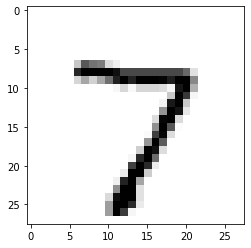

In [48]:
for batch_idx, (features, targets) in enumerate(testloader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.np(), axis=2)
plt.imshow(nhw_img, cmap='Greys');

In [49]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print('Probability 7 %.2f%%' % (probas[0][7]*100))

Probability 7 100.00%


# VGG-11

In [54]:
batch_size = 128
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = []
X_test = []
for i in range(len(x_train)):
    X_train.append(cv2.resize(x_train[i], (32,32)))

for i in range(len(x_test)):
    X_test.append(cv2.resize(x_test[i], (32,32)))

X_train = np.asarray(X_train) 
X_test = np.asarray(X_test)

In [55]:
X_train.shape

(60000, 32, 32)

In [56]:
if K.image_data_format() == 'channels_first':
    x_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    x_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#Convert to float and then normalize the images by dividing by 255(max value of a pixel)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 32, 32, 1)
60000 train samples
10000 test samples


In [57]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [58]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))) 
model.add(Flatten()) 
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         590080    
________________________________________________

In [59]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [61]:
history = model.fit(x_train, y_train, batch_size=32, validation_data=(x_test,y_test), epochs=50, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 26s 429us/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0299 - val_accuracy: 0.9931
Epoch 2/50
60000/60000 [==============================] - 26s 426us/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0319 - val_accuracy: 0.9932
Epoch 3/50
60000/60000 [==============================] - 26s 431us/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0273 - val_accuracy: 0.9928
Epoch 4/50
60000/60000 [==============================] - 26s 435us/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0274 - val_accuracy: 0.9933
Epoch 5/50
60000/60000 [==============================] - 26s 433us/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0482 - val_accuracy: 0.9885
Epoch 6/50
60000/60000 [==============================] - 26s 435us/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0258 - val_accuracy: 0.9940
Epoch 7/50
60000/60000 [==============================] 

In [62]:
score = model.evaluate(x_test, y_test, batch_size=32)
print(score)

10000/10000 [==============================] - 1s 108us/step
[0.03915468179345578, 0.9950000047683716]


In [63]:
print("History", history.history)
print("history.history.keys():", history.history.keys())

History {'val_loss': [0.02985481347111654, 0.031936732702313154, 0.02733881642032793, 0.027415243119829482, 0.0481616064466979, 0.025841349462390372, 0.027564145434548208, 0.030202744358771134, 0.030924471855929003, 0.026621722528792906, 0.02601734539504323, 0.0312846656336116, 0.03067147620036328, 0.03280898527863994, 0.0337333385398045, 0.03403072124937823, 0.03441642385679327, 0.03489387356606428, 0.035264431660077096, 0.03557934233416884, 0.03584798970716468, 0.03609535658875568, 0.03631852499388635, 0.03652027565819296, 0.036705080803320585, 0.03687408210990168, 0.03703283532800749, 0.037182107999894354, 0.03732262187237995, 0.0374514727693562, 0.037576232670394415, 0.03769301618017733, 0.03780605154301113, 0.03791110448789739, 0.03801412233874491, 0.03811417563341995, 0.03820490048934432, 0.038294828947786456, 0.03838108956529425, 0.038462833919552464, 0.03854273798221054, 0.03861900971733255, 0.038695926218425734, 0.03876847038599133, 0.038838030004609, 0.03890446930058813, 0.03

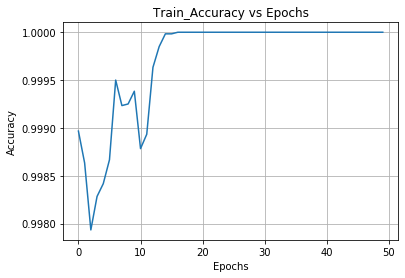

In [65]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Train_Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.show()

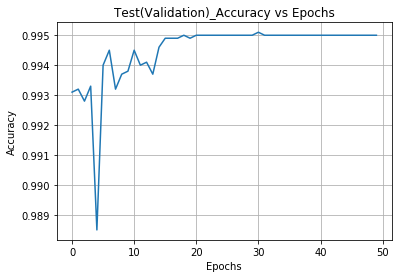

In [67]:
plt.plot(history.history['val_accuracy'])
plt.title('Test(Validation)_Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.show()

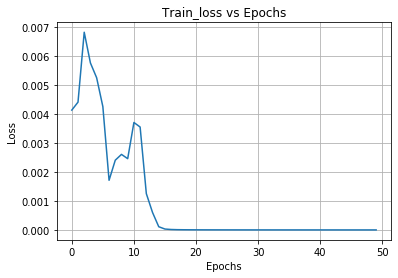

In [68]:
plt.plot(history.history['loss'])
plt.title('Train_loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.show()

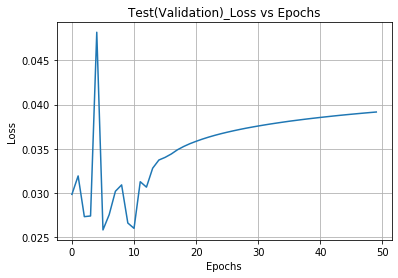

In [69]:

plt.plot(history.history['val_loss'])
plt.title('Test(Validation)_Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.show()